In [10]:
# Pickle is used to save variables as files for future use
import pickle
# NLopt is the optimization libary dadi uses
import nlopt
# MatPlotLib is a libary dadi uses for plotting frequency spectrum
import matplotlib.pyplot as plt
import dadi
import numpy as np


# Import data from vcf files. Ten individuals from either species were included. Fs was folded as ancestor was not used as ref (polarized = False).

In [11]:
dd = dadi.Misc.make_data_dict_vcf("../virchi.10p.SNP.vcf.gz", "../virchi_7_7.list")

In [12]:
fs = dadi.Spectrum.from_data_dict(dd, ['vir', 'chi'], projections = [84, 76], polarized = False)

In [12]:
print(fs.S())

154621.0


In [13]:
fs.mask[0,:] = True
fs.mask[:,0] = True
fs_ma = fs
fs_ma.mask[0:1,:] = True
fs_ma.mask[:,0:1] = True

In [16]:
import os
if not os.path.exists('bootstraps_syn'):
  os.makedirs('bootstraps_syn')
# Nboot is the number of bootstraped datasets we want
# chunk_size is the genome chunks we use to make the
# randomized genomes.
Nboot, chunk_size = 100, 1e7

# Break up the data dictionari into a list of
# dictionary entries for each chunk of the genome.
# Ex, the fist 10^7 base pairs will be element 0,
# the next 10^7 base pairs will be element 1, etc.
# to the last 10^7 base pairs will be the last element/element -1.
chunks = dadi.Misc.fragment_data_dict(dd, chunk_size)

# If we want to do bootstrapping on both the
# synonymous and nonsynonymous variants,
# we want to set a seed so that the same random
# chunks of genome are picked for both.
# The seed needs to be reset to the same value between
# runs of dadi.Misc.bootstraps_from_dd_chunks()
import random
random.seed(123)

# Get a list containin the SFS of the bootstraped genomes.
boots = dadi.Misc.bootstraps_from_dd_chunks(chunks, Nboot, ['vir', 'chi'], [84, 76])

# Save the bootstraps
for i in range(len(boots)):
  boots[i].to_file('bootstraps_syn/virchi.10p.SNP.boot_{0}.fs'.format(str(i)))

# marginalizing vir or chi to compute Waterson's theta and pi

In [22]:
fsvir = fs.marginalize([1])
fschi = fs.marginalize([0])

In [23]:
theta = [fsvir.Watterson_theta(), fschi.Watterson_theta()]
Tajima = [fsvir.Tajima_D(), fschi.Tajima_D()]


# Build a split with migration model 

In [14]:
def split_mig1(params, ns, pts):
    nu1, nu2, T, m12, m21 = params
    xx = dadi.Numerics.default_grid(pts)

    phi = dadi.PhiManip.phi_1D(xx)
    phi = dadi.PhiManip.phi_1D_to_2D(xx, phi)
    phi = dadi.Integration.two_pops(phi, xx, T, nu1, nu2, m12 = m12, m21 = m21)

    fs = dadi.Spectrum.from_phi(phi, ns, (xx, xx))
    return fs

Set initial parameters

In [15]:
ns = fs.sample_sizes
pts_l = [max(ns)+20, max(ns)+30, max(ns)+40]
params = [0.4549, 0.034, 0.0189, 0.0238, 0.0296]
lower_bounds = [1e-3, 1e-3, 1e-10, 1e-3, 1e-3]
upper_bounds = [3, 3, 10, 1, 1]

create extrapolate function

In [16]:
demo_model_ex = dadi.Numerics.make_extrap_func(split_mig1)

Optimize parameters

In [17]:
try:
  fid = open('migmodel_fit_refinedPop_t10.txt','a')
except:
  fid = open('migmodel_fit_refinedPop_t10.txt','w')
for i in range(30):
    p0 = dadi.Misc.perturb_params(params, fold=1, upper_bound=upper_bounds,
                                  lower_bound=lower_bounds)
    popt, ll_model = dadi.Inference.opt(p0, fs, demo_model_ex, pts_l,
                                        lower_bound=lower_bounds,
                                        upper_bound=upper_bounds,
                                        maxeval=400, verbose=100)
    # Calculate the synonymous theta
    model_fs = demo_model_ex(popt, ns, pts_l)
    theta0 = dadi.Inference.optimal_sfs_scaling(model_fs, fs)

    # Write results to fid
    res = [ll_model] + list(popt) + [theta0]
    fid.write('\t'.join([str(ele) for ele in res])+'\n')
fid.close()

11700   , -27098.2    , array([ 0.1341     ,  0.0453203  ,  0.0207767  ,  0.0409554  ,  0.0382572  ])
11800   , -23721.8    , array([ 2.82216    ,  0.329767   ,  0.222339   ,  0.172621   ,  0.103603   ])
11900   , -22582.7    , array([ 0.510472   ,  0.499662   ,  0.19554    ,  0.329452   ,  0.254421   ])
12000   , -22517.5    , array([ 0.522341   ,  0.50208    ,  0.200848   ,  0.404078   ,  0.268733   ])


12100   , -26952.7    , array([ 0.102425   ,  0.0334126  ,  0.0160108  ,  0.145934   ,  0.0709344  ])
12200   , -22444      , array([ 0.411041   ,  0.352318   ,  0.147447   ,  0.650527   ,  0.383077   ])
12300   , -22410.3    , array([ 0.362782   ,  0.36547    ,  0.14395    ,  0.63337    ,  0.444398   ])
12400   , -22399.8    , array([ 0.349669   ,  0.345631   ,  0.136802   ,  0.660944   ,  0.485439   ])
12500   , -26044.5    , array([ 2.99715    ,  0.0676662  ,  0.0452937  ,  0.0343563  ,  0.548256   ])
12600   , -23157      , array([ 1.27974    ,  0.377608   ,  0.256162   ,  0.30238    ,  0.302057   ])
12700   , -22571.5    , array([ 0.644063   ,  0.529791   ,  0.224836   ,  0.30324    ,  0.240235   ])
12800   , -22521.7    , array([ 0.531323   ,  0.470969   ,  0.196768   ,  0.369995   ,  0.298008   ])


12900   , -27186.5    , array([ 0.228426   ,  0.0414695  ,  0.0214649  ,  0.0134987  ,  0.0174177  ])
13000   , -26767.2    , array([ 0.186821   ,  0.0880882  ,  0.0375242  ,  0.0785888  ,  0.0619552  ])
13100   , -22647.2    , array([ 0.765385   ,  0.639114   ,  0.270505   ,  0.25991    ,  0.174778   ])
13200   , -22589.9    , array([ 0.704899   ,  0.53169    ,  0.237007   ,  0.288276   ,  0.215854   ])
13300   , -27243.3    , array([ 0.458071   ,  0.0409344  ,  0.0245261  ,  0.0244131  ,  0.0222895  ])
13400   , -26683.2    , array([ 0.355479   ,  0.0988689  ,  0.0479104  ,  0.0777861  ,  0.0508317  ])
13500   , -22514.9    , array([ 0.535331   ,  0.470354   ,  0.195677   ,  0.398072   ,  0.270776   ])
13600   , -22482.6    , array([ 0.473085   ,  0.454754   ,  0.182221   ,  0.438526   ,  0.342747   ])
13700   , -26999.2    , array([ 0.54594    ,  0.065213   ,  0.038251   ,  0.0612945  ,  0.0427809  ])
13800   , -22538.5    , array([ 0.630251   ,  0.409868   ,  0.191647   ,  0.374083

15300   , -27129.2    , array([ 0.63664    ,  0.0439831  ,  0.0250949  ,  0.0184537  ,  0.0428027  ])
15400   , -23161.4    , array([ 0.903312   ,  0.302211   ,  0.181802   ,  0.29976    ,  0.530572   ])
15500   , -22498      , array([ 0.517367   ,  0.467517   ,  0.191752   ,  0.415797   ,  0.299274   ])
15600   , -22484.7    , array([ 0.490416   ,  0.449285   ,  0.183742   ,  0.432334   ,  0.323835   ])


15700   , -27210.6    , array([ 0.371866   ,  0.0171424  ,  0.0101315  ,  0.0317733  ,  0.016089   ])
15800   , -27267      , array([ 0.207268   ,  0.0260931  ,  0.0152719  ,  0.0491746  ,  0.0287575  ])
15900   , -23982.3    , array([ 1.0734     ,  0.327674   ,  0.168804   ,  0.277312   ,  0.0581558  ])
16000   , -22506.3    , array([ 0.530073   ,  0.415751   ,  0.181764   ,  0.426481   ,  0.289524   ])
16100   , -27134.9    , array([ 0.427256   ,  0.0416721  ,  0.0237215  ,  0.040943   ,  0.0207808  ])
16200   , -26482.4    , array([ 0.253464   ,  0.115153   ,  0.0499183  ,  0.100537   ,  0.0668173  ])
16300   , -22505.1    , array([ 0.487558   ,  0.492984   ,  0.190986   ,  0.40416    ,  0.294454   ])
16400   , -22458.8    , array([ 0.443348   ,  0.405376   ,  0.165788   ,  0.484709   ,  0.370598   ])
16500   , -27085.7    , array([ 0.226441   ,  0.0758088  ,  0.0354133  ,  0.0282689  ,  0.0215985  ])
16600   , -23895.6    , array([ 0.794411   ,  0.271095   ,  0.148667   ,  0.210203

17300   , -27102.8    , array([ 0.0655598  ,  0.058755   ,  0.0187464  ,  0.0362843  ,  0.0492896  ])
17400   , -26918.8    , array([ 0.105576   ,  0.074574   ,  0.0271591  ,  0.0597057  ,  0.079403   ])
17500   , -22505      , array([ 0.546316   ,  0.443606   ,  0.193976   ,  0.40598    ,  0.312399   ])
17600   , -22430.4    , array([ 0.320246   ,  0.410859   ,  0.142649   ,  0.672359   ,  0.451084   ])


17700   , -27145.8    , array([ 0.482214   ,  0.0629066  ,  0.0334992  ,  0.0177149  ,  0.0184576  ])
17800   , -26134.1    , array([ 0.650137   ,  0.227453   ,  0.108007   ,  0.0779257  ,  0.0238241  ])
17900   , -22814.2    , array([ 1.05272    ,  0.819002   ,  0.370691   ,  0.147234   ,  0.113874   ])
18000   , -22579.4    , array([ 0.669757   ,  0.534872   ,  0.232695   ,  0.29336    ,  0.235012   ])


18100   , -27174.8    , array([ 0.0494493  ,  0.0277212  ,  0.0109225  ,  0.0351834  ,  0.0359791  ])
18200   , -27103.9    , array([ 0.0795296  ,  0.0357789  ,  0.01509    ,  0.0553763  ,  0.048114   ])
18300   , -22817.2    , array([ 0.542201   ,  0.232805   ,  0.12251    ,  0.568147   ,  0.304769   ])
18400   , -22394.7    , array([ 0.337175   ,  0.316357   ,  0.127576   ,  0.707113   ,  0.490662   ])
18500   , -27200.9    , array([ 0.527433   ,  0.0211867  ,  0.0123977  ,  0.0201983  ,  0.0250634  ])
18600   , -27050.7    , array([ 0.268177   ,  0.0683871  ,  0.0337645  ,  0.0210097  ,  0.0504462  ])
18700   , -22569      , array([ 0.583103   ,  0.535314   ,  0.217732   ,  0.307555   ,  0.252073   ])
18800   , -22533.1    , array([ 0.496193   ,  0.549205   ,  0.203929   ,  0.38358    ,  0.273798   ])


18900   , -27135.9    , array([ 0.121855   ,  0.0425895  ,  0.0192691  ,  0.0166134  ,  0.0556321  ])
19000   , -27086.2    , array([ 0.379326   ,  0.0490748  ,  0.0272973  ,  0.0163486  ,  0.0665484  ])
19100   , -22931.8    , array([ 1.60942    ,  0.459544   ,  0.278412   ,  0.167853   ,  0.186529   ])
19200   , -22623.4    , array([ 0.699744   ,  0.578441   ,  0.250851   ,  0.286978   ,  0.251261   ])


19300   , -27662.6    , array([ 0.281226   ,  0.0185012  ,  0.012326   ,  0.0219372  ,  0.0342558  ])
19400   , -26165.4    , array([ 1.63577    ,  0.0842074  ,  0.0541526  ,  0.038107   ,  0.333817   ])
19500   , -22904.3    , array([ 1.48747    ,  0.422829   ,  0.264301   ,  0.22967    ,  0.194494   ])
19600   , -22544.4    , array([ 0.558494   ,  0.531659   ,  0.213773   ,  0.338923   ,  0.25981    ])
19700   , -27056.6    , array([ 0.740468   ,  0.0680682  ,  0.0388061  ,  0.0412449  ,  0.0174221  ])
19800   , -22752.2    , array([ 0.693765   ,  0.564956   ,  0.244216   ,  0.305176   ,  0.142861   ])
19900   , -22604      , array([ 0.632514   ,  0.623837   ,  0.245143   ,  0.282807   ,  0.203696   ])
20000   , -22507.4    , array([ 0.502917   ,  0.476691   ,  0.190187   ,  0.409651   ,  0.280592   ])


20100   , -27210.9    , array([ 0.152603   ,  0.0272491  ,  0.0136525  ,  0.0325529  ,  0.0151949  ])
20200   , -27091.9    , array([ 0.187095   ,  0.0390271  ,  0.019805   ,  0.0577647  ,  0.0283901  ])
20300   , -23406.6    , array([ 1.18962    ,  0.248134   ,  0.162004   ,  0.556469   ,  0.197236   ])
20400   , -22625.9    , array([ 0.389054   ,  0.371007   ,  0.148875   ,  0.710235   ,  0.273629   ])


20500   , -27111.5    , array([ 0.690515   ,  0.0542515  ,  0.030096   ,  0.0316515  ,  0.0306854  ])
20600   , -22754      , array([ 0.92519    ,  0.720848   ,  0.325252   ,  0.169723   ,  0.149721   ])
20700   , -22664.1    , array([ 0.76455    ,  0.680509   ,  0.283084   ,  0.226179   ,  0.186599   ])
20800   , -22553.5    , array([ 0.57171    ,  0.475741   ,  0.206977   ,  0.341471   ,  0.299667   ])
20900   , -27314.1    , array([ 0.454266   ,  0.0493398  ,  0.0249565  ,  0.0141348  ,  0.0448722  ])
21000   , -24444.2    , array([ 2.43136    ,  0.281092   ,  0.213051   ,  0.101467   ,  0.427924   ])
21100   , -22712.1    , array([ 0.940542   ,  0.535819   ,  0.266236   ,  0.202173   ,  0.206276   ])
21200   , -22638.3    , array([ 0.680026   ,  0.678791   ,  0.26655    ,  0.251887   ,  0.194618   ])


21300   , -27165.6    , array([ 0.555064   ,  0.0304518  ,  0.0176993  ,  0.044739   ,  0.0177011  ])
21400   , -26986.3    , array([ 0.135462   ,  0.0548212  ,  0.0238973  ,  0.0912132  ,  0.0158467  ])
21500   , -23176.8    , array([ 0.418707   ,  0.196022   ,  0.0965763  ,  0.683472   ,  0.246497   ])
21600   , -22450.1    , array([ 0.36043    ,  0.348174   ,  0.13906    ,  0.695697   ,  0.376802   ])
21700   , -27336.8    , array([ 0.451022   ,  0.0371655  ,  0.0236168  ,  0.0403066  ,  0.0614175  ])
21800   , -26003.7    , array([ 0.413859   ,  0.103874   ,  0.0562688  ,  0.142148   ,  0.151636   ])
21900   , -22490.2    , array([ 0.448474   ,  0.364506   ,  0.156363   ,  0.468101   ,  0.425099   ])
22000   , -22446.4    , array([ 0.416686   ,  0.413779   ,  0.162343   ,  0.518315   ,  0.378793   ])
22100   , -28342.4    , array([ 0.694372   ,  0.0463719  ,  0.0345668  ,  0.0354715  ,  0.040566   ])
22200   , -22756.4    , array([ 0.708695   ,  0.344584   ,  0.177053   ,  0.287616

22500   , -27235.1    , array([ 0.495226   ,  0.0308691  ,  0.0186105  ,  0.0127482  ,  0.0260234  ])
22600   , -27125.6    , array([ 0.699118   ,  0.0395857  ,  0.0229123  ,  0.0254796  ,  0.0455808  ])
22700   , -25966.8    , array([ 0.424138   ,  0.15027    ,  0.0712186  ,  0.0769964  ,  0.156434   ])
22800   , -22828.1    , array([ 0.536179   ,  0.449029   ,  0.212856   ,  0.320478   ,  0.281037   ])
22900   , -27119.2    , array([ 0.423815   ,  0.0370023  ,  0.0219421  ,  0.038507   ,  0.0705251  ])
23000   , -23043.4    , array([ 1.73964    ,  0.436565   ,  0.257793   ,  0.16601    ,  0.206232   ])
23100   , -22502.7    , array([ 0.410377   ,  0.479129   ,  0.178667   ,  0.463452   ,  0.375905   ])
23200   , -22449.9    , array([ 0.404148   ,  0.419097   ,  0.164497   ,  0.531747   ,  0.398284   ])


# plot demographic inference

58124.68799813111


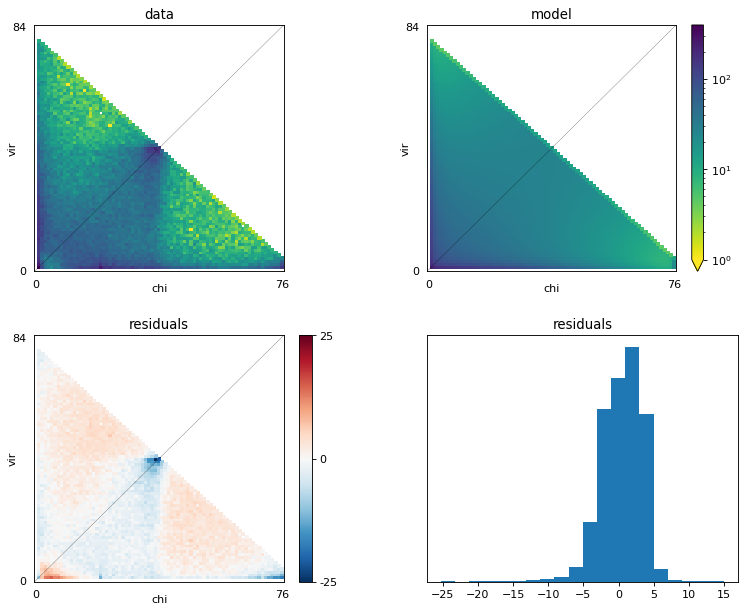

In [25]:
#popt from the best model without masking singleton
#popt = [0.01150, 0.01, 0.0036, 0.0379, 0.0561]
#popt from the best model after masking singleton
#popt = [0.0112, 0.01, 0.0036, 0.0317, 0.0246]
#popt from the best model after masking 0 allele in eachpop
#popt = [0.4549, 0.034, 0.0189, 0.0238, 0.0296]
#prot from the best model with updated initial parameters, 
popt = [0.3222, 0.3221, 0.1267, 0.7407, 0.51814]

model_fs = demo_model_ex(popt, ns, pts_l)
theta0 = dadi.Inference.optimal_sfs_scaling(model_fs, fs)
print(theta0)
fig = plt.figure(figsize=(10, 8), dpi=80)
fig.clear()
dadi.Plotting.plot_2d_comp_multinom(model_fs, fs, vmin=1, pop_ids =('vir','chi'))
fig.savefig('migmodel_SFS_plot.png')

In [20]:
# Load bootstraped frequency spectrum (if they haven't been made, there is an example in the "Creating a frequency spectrum" section)
import glob
boots_fids = glob.glob('bootstraps_syn/virchi.10p.SNP.boot_*.fs')
boots_syn = [dadi.Spectrum.from_file(fid) for fid in boots_fids]

# Godambe uncertainties
# Will contain uncertainties for the
# estimated demographic parameters and theta.

# Start a file to contain the confidence intervals
fi = open('demographic_confidence_intervals.txt','w')
fi.write('Optimized parameters: {0}\n\n'.format(popt))

# we want to try a few different step sizes (eps) to see if
# uncertainties very wildly with changes to step size.
for eps in [0.01, 0.001, 0.0001]:
    uncerts_adj = dadi.Godambe.GIM_uncert(demo_model_ex, pts_l, boots_syn, popt, fs, eps=eps)
    fi.write('Estimated 95% uncerts (with step size '+str(eps)+'): {0}\n'.format(1.96*uncerts_adj[:-1]))
    fi.write('Lower bounds of 95% confidence interval : {0}\n'.format(popt-1.96*uncerts_adj[:-1]))
    fi.write('Upper bounds of 95% confidence interval : {0}\n\n'.format(popt+1.96*uncerts_adj[:-1]))
fi.close()

# likelihood ratio test

In [30]:
p0 = [0.3222, 0.3221, 0.1267, 0, 0] 
model_nomig = demo_model_ex(p0, ns, pts_l)
ll_nomig = dadi.Inference.ll_multinom(model_nomig, fs)
full_model = demo_model_ex(popt, ns, pts_l)
ll_full = dadi.Inference.ll_multinom(full_model, fs)
print(f"Likelihood of Full model is {ll_full}; reduced model with no migration is {ll_nomig}." )

Likelihood of Full model is -22382.789221812604; reduced model with no migration is -28521.236080099156.


In [36]:
nested_indices = [3, 4]
adj = dadi.Godambe.LRT_adjust(demo_model_ex, pts_l, boots_syn, popt, fs, nested_indices, multinom = True)
D_adj = adj*2*(ll_full - ll_nomig)
print('Adjusted D statistic: {0:.4f}'.format(D_adj))
pval = dadi.Godambe.sum_chi2_ppf(D_adj, weights=(0.5,0.5))
print('p-value for rejecting no-migration model: {0:.100f}'.format(pval))

Adjusted D statistic: 12528.7064
p-value for rejecting no-migration model: 0.0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
